In [2]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from sklearn.model_selection import train_test_split

# ----------------------------------------
# 1. 准备图像列表并划分 75% 训练 / 25% 验证
# ----------------------------------------
patches_folder = r"train_patches_XY"
all_fns = sorted([f for f in os.listdir(patches_folder) if f.lower().endswith(".png")])
all_indices = list(range(len(all_fns)))
train_idxs, val_idxs = train_test_split(all_indices, test_size=0.25, random_state=42)

# ----------------------------------------
# 2. 定义只用旋转增强（×2）的 Dataset，新版：先 8× 下采样 → 线性插值回 256×256 → 旋转
# ----------------------------------------
class RotLowHighDataset(Dataset):
    """
    对每张原图：
      1. 8× 下采样得到 32×256
      2. 线性插值 (Bilinear) 将 32×256 上采样回 256×256 → 作为输入
      3. 原图 256×256 作为目标
      4. 再旋转 90° 作为增强
    返回 (inp_tensor, tgt_tensor)，均为 [1,256,256]
    """
    def __init__(self, patches_folder, indices, transform=None):
        super().__init__()
        self.patches_folder = patches_folder
        self.indices = indices
        self.transform = transform or transforms.ToTensor()
        self.fns = [all_fns[i] for i in indices]

    def __len__(self):
        # 每张原图返回两个样本：原向 + 90° 旋转
        return len(self.fns) * 2

    def __getitem__(self, idx):
        img_idx = idx // 2
        rot_flag = idx % 2  # 0→不旋转, 1→逆时针90°

        fn = self.fns[img_idx]
        img_path = os.path.join(self.patches_folder, fn)
        img = Image.open(img_path).convert("L")
        arr = np.array(img)  # shape (256,256)

        # 如果需要，先对原图做旋转
        if rot_flag == 1:
            arr = np.rot90(arr, k=1)

        # 下采样：竖向每 8 行保留一行 → shape (32,256)
        down_arr = arr[::8, :]

        # 线性插值（PIL.BILINEAR）将 (32,256) 上采样到 (256,256)
        down_img = Image.fromarray(down_arr)
        up_img = down_img.resize((256, 256), resample=Image.BILINEAR)

        # 原始目标图也要保持同样旋转状态
        tgt_img = Image.fromarray(arr)

        # 转为 Tensor [1,256,256]
        inp_t = self.transform(up_img)
        tgt_t = self.transform(tgt_img)
        return inp_t, tgt_t

# ----------------------------------------
# 3. 定义仅旋转增强的验证集 Dataset（无旋转、不做增强）
# ----------------------------------------
class PlainLowHighDataset(Dataset):
    """
    对验证集：
      1. 8× 下采样得到 32×256
      2. 线性插值回 256×256 → 输入
      3. 原图 256×256 → 目标
      不做旋转、不做增强
    """
    def __init__(self, patches_folder, indices, transform=None):
        super().__init__()
        self.patches_folder = patches_folder
        self.indices = indices
        self.transform = transform or transforms.ToTensor()
        self.fns = [all_fns[i] for i in indices]

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        img = Image.open(img_path).convert("L")
        arr = np.array(img)

        # 下采样：32×256
        down_arr = arr[::8, :]

        # 线性插值回 256×256
        down_img = Image.fromarray(down_arr)
        up_img = down_img.resize((256, 256), resample=Image.BILINEAR)

        # 转为 Tensor
        inp_t = self.transform(up_img)
        tgt_t = self.transform(img)
        return inp_t, tgt_t

# ----------------------------------------
# 4. 定义 UNet256 模型：不含可学习的转置卷积，仅用双线性插值上采样
#     输入 [B,1,256,256] → 输出 [B,1,256,256]
# ----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet256(nn.Module):
    """
    UNet 结构版本：输入 [B,1,256,256]，输出 [B,1,256,256]
    Encoder 降采样靠 MaxPool2d((2,2))
    Decoder 上采样靠 F.interpolate(scale_factor=2, mode='bilinear')
    """
    def __init__(self, in_ch=1, out_ch=1, base=64):
        super().__init__()
        # Encoder: 256→128→64→32→16
        self.enc1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(base*4, base*8)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck at 16×16
        self.bottleneck = DoubleConv(base*8, base*16)

        # Decoder: 16→32→64→128→256
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec4 = DoubleConv(base*16 + base*8, base*8)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec3 = DoubleConv(base*8 + base*4, base*4)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = DoubleConv(base*4 + base*2, base*2)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = DoubleConv(base*2 + base, base)

        # 最后 1×1 卷积
        self.outc = nn.Conv2d(base, out_ch, kernel_size=1)

    def forward(self, x):
        # Encoding
        e1 = self.enc1(x)     # [B, base,256,256]
        p1 = self.pool1(e1)   # [B, base,128,128]
        e2 = self.enc2(p1)    # [B, base*2,128,128]
        p2 = self.pool2(e2)   # [B, base*2,64,64]
        e3 = self.enc3(p2)    # [B, base*4,64,64]
        p3 = self.pool3(e3)   # [B, base*4,32,32]
        e4 = self.enc4(p3)    # [B, base*8,32,32]
        p4 = self.pool4(e4)   # [B, base*8,16,16]

        # Bottleneck
        b = self.bottleneck(p4)  # [B, base*16,16,16]

        # Decoding with bilinear upsampling
        u4 = self.up4(b)                           # [B, base*16,32,32]
        d4 = self.dec4(torch.cat([u4, e4], dim=1)) # [B, base*8,32,32]
        u3 = self.up3(d4)                          # [B, base*8,64,64]
        d3 = self.dec3(torch.cat([u3, e3], dim=1)) # [B, base*4,64,64]
        u2 = self.up2(d3)                          # [B, base*4,128,128]
        d2 = self.dec2(torch.cat([u2, e2], dim=1)) # [B, base*2,128,128]
        u1 = self.up1(d2)                          # [B, base*2,256,256]
        d1 = self.dec1(torch.cat([u1, e1], dim=1)) # [B, base,256,256]

        out = self.outc(d1)  # [B,1,256,256]
        return out

# ----------------------------------------
# 5. 创建训练/验证 DataLoader
# ----------------------------------------
batch_size = 8
transform = transforms.ToTensor()

train_dataset = RotLowHighDataset(patches_folder, train_idxs, transform)
val_dataset   = PlainLowHighDataset(patches_folder, val_idxs,   transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)

print(f"总样本数: {len(all_fns)}, 训练集: {len(train_dataset)} (含旋转增强×2), 验证集: {len(val_dataset)} (无增强)")

# ----------------------------------------
# 6. 训练循环（15 epochs，使用带高频偏好的损失）
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet256().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

os.makedirs("Train_UNet256_hf", exist_ok=True)

# 基础 MSE 损失
criterion = nn.MSELoss()

# 高频偏好部分：使用拉普拉斯高通核提取高频
laplacian_kernel = torch.tensor(
    [[0.0, -1.0, 0.0],
     [-1.0, 4.0, -1.0],
     [0.0, -1.0, 0.0]],
    device=device
).view(1, 1, 3, 3)

lambda_hf = 0.5  # 高频损失权重

def high_freq_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    对 pred 和 target 应用拉普拉斯高通滤波，然后计算它们之间的 MSE。
    输入 pred, target: [B,1,256,256]
    """
    pred_lap = F.conv2d(pred, laplacian_kernel, padding=1)
    tgt_lap  = F.conv2d(target, laplacian_kernel, padding=1)
    return F.mse_loss(pred_lap, tgt_lap)

num_epochs = 15

for epoch in range(1, num_epochs + 1):
    # ———— 6.1 训练 ————
    model.train()
    train_loss = 0.0
    for inp, tgt in train_loader:
        inp, tgt = inp.to(device), tgt.to(device)
        optimizer.zero_grad()
        out = model(inp)  # [B,1,256,256]

        mse = criterion(out, tgt)
        hf  = high_freq_loss(out, tgt)
        loss = mse + lambda_hf * hf

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inp.size(0)
    train_loss /= len(train_loader.dataset)

    # ———— 6.2 验证 ————
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inp_v, tgt_v in val_loader:
            inp_v, tgt_v = inp_v.to(device), tgt_v.to(device)
            out_v = model(inp_v)

            mse_v = criterion(out_v, tgt_v)
            hf_v  = high_freq_loss(out_v, tgt_v)
            loss_v = mse_v + lambda_hf * hf_v
            val_loss += loss_v.item() * inp_v.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # 保存模型权重
    torch.save(model.state_dict(), f"Train_UNet256_hf/UNet256_epoch{epoch:02d}.pth")

print("训练完毕，模型保存在 Train_UNet256_hf/")


总样本数: 1024, 训练集: 1536 (含旋转增强×2), 验证集: 256 (无增强)


KeyboardInterrupt: 

In [ ]:
# ----------------------------------------
# 2. 测试集路径 & 输出文件夹
# ----------------------------------------
test_folder  = "test_patches_YZ"       # 包含完整 256×256 切片
down_folder  = "test_down8_YZ"         # 用于保存 1/8 下采样的 32×256 图
output_folder = "test_HR_outputs_YZ"      # 用于保存 上采样回 256×256
os.makedirs(down_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# ----------------------------------------
# 3. 载入模型权重
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet256(in_ch=1, out_ch=1, base=64).to(device)
ckpt_path = "./UNetUp8_finetuned_pure_perceptual.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

# ----------------------------------------
# 4. 逐张读取 test_patches_YZ，做 1/8 下采样 → 上采样 → 计算 PSNR/SSIM
# ----------------------------------------
transform = transforms.ToTensor()

total_psnr = 0.0
total_ssim = 0.0
count = 0

for fn in sorted(os.listdir(test_folder)):
    if not fn.lower().endswith(".png"):
        continue

    # 4.1 读取原始 256×256 切片
    img_path = os.path.join(test_folder, fn)
    orig_img = Image.open(img_path).convert("L")
    orig_arr = np.array(orig_img)  # shape: (256, 256)

    # 4.2 下采样：竖向每 8 行保留一行 → 得到 32×256
    down_arr = orig_arr[::8, :]
    down_img = Image.fromarray(down_arr)
    down_img.save(os.path.join(down_folder, fn))  # 可选：把下采样图存盘以便查看

    # 4.3 转 Tensor 送入网络：[1,1,32,256], 归一化 [0,1]
    inp_t = transform(down_img).unsqueeze(0).to(device)

    # 4.4 上采样推理
    with torch.no_grad():
        out_t = model(inp_t)  # [1,1,256,256], 值域 [0,1]
    out_np = (out_t.squeeze().cpu().numpy() * 255.0).round().clip(0, 255).astype(np.uint8)

    # 4.5 保存输出 256×256 上采样图
    Image.fromarray(out_np).save(os.path.join(output_folder, fn))

    # 4.6 计算指标
    psnr_val = peak_signal_noise_ratio(orig_arr, out_np, data_range=255)
    ssim_val = structural_similarity(orig_arr, out_np, data_range=255)

    total_psnr += psnr_val
    total_ssim += ssim_val
    count += 1

    

# 平均指标
if count > 0:
    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count
    print(f"\n[Test YZ] 1/8 → UNetUp8 Epoch15:  Avg PSNR = {avg_psnr:.2f} dB, Avg SSIM = {avg_ssim:.4f}")
else:
    print("测试文件夹中没有找到 PNG 图像。")

In [2]:
# ----------------------------------------
# 验证 Cell：使用验证集计算 SSIM 和 PSNR
# ----------------------------------------
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim_metric, peak_signal_noise_ratio as psnr_metric

# ----------------------------------------
# 1. 定义验证集 Dataset（回顾 PlainLowHighDataset 逻辑）
# ----------------------------------------
class PlainLowHighDataset(Dataset):
    """
    验证集：对每张原图做 8× 下采样 → 32×256，
    再用双线性插值回 256×256，作为低分辨率输入；
    原图 256×256 作为目标。
    """
    def __init__(self, patches_folder, indices, transform=None):
        super().__init__()
        self.patches_folder = patches_folder
        self.indices = indices
        self.transform = transform or transforms.ToTensor()
        self.fns = [all_fns[i] for i in indices]

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        img = Image.open(img_path).convert("L")
        arr = np.array(img)  # shape (256,256)

        # 下采样 8× → (32,256)
        down_arr = arr[::8, :]

        # 双线性插值回 (256,256)
        down_img = Image.fromarray(down_arr)
        up_img = down_img.resize((256, 256), resample=Image.BILINEAR)

        inp_t = self.transform(up_img)  # [1,256,256], float in [0,1]
        tgt_t = self.transform(img)     # [1,256,256], float in [0,1]
        return inp_t, tgt_t, fn  # 返回文件名方便记录

# ----------------------------------------
# 2. 加载验证集索引与 DataLoader
# ----------------------------------------
patches_folder = r"train_patches_XY"
all_fns = sorted([f for f in os.listdir(patches_folder) if f.lower().endswith(".png")])
all_indices = list(range(len(all_fns)))
_, val_idxs = train_test_split(all_indices, test_size=0.25, random_state=42)  # 之前的划分

transform = transforms.ToTensor()
val_dataset = PlainLowHighDataset(patches_folder, val_idxs, transform)
val_loader  = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

# ----------------------------------------
# 3. 加载模型结构与权重（选择你想评估的 epoch，比如 Epoch15）
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet256().to(device)
# 修改为你实际保存的权重路径
checkpoint_path = "Train_UNet256_hf/UNet256_epoch15.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# ----------------------------------------
# 4. 定义度量函数：PSNR 和 SSIM
# ----------------------------------------
def compute_metrics(pred: np.ndarray, target: np.ndarray):
    """
    pred, target: numpy arrays, shape (H,W), dtype float32 or float64, values in [0,1]
    返回 (psnr_value, ssim_value)
    """
    # 将 float 数值转成 [0,1] 范围
    pred_clamped = np.clip(pred, 0.0, 1.0)
    target_clamped = np.clip(target, 0.0, 1.0)
    # 转化为 0-255 进行度量
    pred_255 = (pred_clamped * 255.0).round().astype(np.uint8)
    tgt_255  = (target_clamped * 255.0).round().astype(np.uint8)

    psnr_val = psnr_metric(tgt_255, pred_255, data_range=255)
    ssim_val = ssim_metric(tgt_255, pred_255, data_range=255)
    return psnr_val, ssim_val

# ----------------------------------------
# 5. 在验证集上进行推理并统计平均 PSNR/SSIM
# ----------------------------------------
total_psnr = 0.0
total_ssim = 0.0
n = 0

with torch.no_grad():
    for inp_t, tgt_t, fn in val_loader:
        inp_t = inp_t.to(device)   # [1,1,256,256]
        tgt_t = tgt_t.to(device)   # [1,1,256,256]

        out_t = model(inp_t)       # [1,1,256,256]
        out_t = torch.sigmoid(out_t) if out_t.min() < 0 or out_t.max() > 1 else out_t
        # 如果模型输出未经 Sigmoid，可视情况添加 Sigmoid 或 clamp

        # 转 NumPy
        pred_np = out_t.squeeze().cpu().numpy()
        tgt_np  = tgt_t.squeeze().cpu().numpy()

        psnr_val, ssim_val = compute_metrics(pred_np, tgt_np)
        total_psnr += psnr_val
        total_ssim += ssim_val
        n += 1

avg_psnr = total_psnr / n
avg_ssim = total_ssim / n
print(f"验证集结果：Avg PSNR = {avg_psnr:.2f} dB, Avg SSIM = {avg_ssim:.4f}")


C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_3872\271316841.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_loc

验证集结果：Avg PSNR = 29.71 dB, Avg SSIM = 0.7372


In [4]:
# ----------------------------------------
# Cell: 计算测试集上的 PSNR/SSIM 并保存所有预测图像（修正）
# ----------------------------------------
import os
import torch
from PIL import Image
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim_metric, peak_signal_noise_ratio as psnr_metric

# 1. 测试集 DataLoader 已定义为 test_loader，返回 (inp, tgt, fn)

# 2. 定义并加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet256().to(device)
checkpoint_path = "Train_UNet256_hf/UNet256_epoch09.pth"  # 请替换为实际路径
state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# 3. 准备输出文件夹
output_dir = "test_predictions"
os.makedirs(output_dir, exist_ok=True)

# 4. 度量函数
def compute_metrics(pred, target):
    pred = np.clip(pred, 0.0, 1.0)
    target = np.clip(target, 0.0, 1.0)
    pred_u8   = (pred * 255).round().astype(np.uint8)
    target_u8 = (target * 255).round().astype(np.uint8)
    return psnr_metric(target_u8, pred_u8, data_range=255), \
           ssim_metric(target_u8, pred_u8, data_range=255)

# 5. 推理循环
total_psnr, total_ssim, n = 0.0, 0.0, 0

with torch.no_grad():
    for inp_t, tgt_t, fn in test_loader:
        # fn 可能是 tuple, 解包取第一个
        if isinstance(fn, (tuple, list)):
            fn = fn[0]
        # 推理
        inp_t = inp_t.to(device)    # [1,1,256,256]
        tgt_t = tgt_t.to(device)
        out_t = model(inp_t).clamp(0,1).cpu().squeeze().numpy()  # [256,256]
        tgt_np = tgt_t.cpu().squeeze().numpy()

        # 计算指标
        p, s = compute_metrics(out_t, tgt_np)
        total_psnr += p
        total_ssim += s
        n += 1

        # 保存图像
        save_path = os.path.join(output_dir, fn)
        Image.fromarray((out_t * 255).round().astype(np.uint8)).save(save_path)

# 6. 打印平均结果
print(f"测试集：Avg PSNR = {total_psnr/n:.2f} dB, Avg SSIM = {total_ssim/n:.4f}")
print(f"所有预测图像已保存到: {output_dir}/")


测试集：Avg PSNR = 16.89 dB, Avg SSIM = 0.4412
所有预测图像已保存到: test_predictions/


C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_30784\2176624577.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt, map_location=device)


Epoch 01 | Val PSNR=27.72, SSIM=0.7820 | Test PSNR=16.02, SSIM=0.2724
Epoch 02 | Val PSNR=28.01, SSIM=0.7938 | Test PSNR=16.31, SSIM=0.3287
Epoch 03 | Val PSNR=28.09, SSIM=0.7997 | Test PSNR=16.35, SSIM=0.3521
Epoch 04 | Val PSNR=28.22, SSIM=0.8059 | Test PSNR=16.47, SSIM=0.3763
Epoch 05 | Val PSNR=28.40, SSIM=0.8160 | Test PSNR=16.65, SSIM=0.4070
Epoch 06 | Val PSNR=28.45, SSIM=0.8213 | Test PSNR=16.68, SSIM=0.4264
Epoch 07 | Val PSNR=28.46, SSIM=0.8247 | Test PSNR=16.70, SSIM=0.4296
Epoch 08 | Val PSNR=28.58, SSIM=0.8263 | Test PSNR=16.82, SSIM=0.4350
Epoch 09 | Val PSNR=28.67, SSIM=0.8290 | Test PSNR=16.89, SSIM=0.4413
Epoch 10 | Val PSNR=28.71, SSIM=0.8309 | Test PSNR=16.93, SSIM=0.4475
Epoch 11 | Val PSNR=28.76, SSIM=0.8325 | Test PSNR=16.94, SSIM=0.4459
Epoch 12 | Val PSNR=28.78, SSIM=0.8340 | Test PSNR=17.02, SSIM=0.4555
Epoch 13 | Val PSNR=28.76, SSIM=0.8327 | Test PSNR=17.06, SSIM=0.4553
Epoch 14 | Val PSNR=28.82, SSIM=0.8349 | Test PSNR=17.08, SSIM=0.4538
Epoch 15 | Val PSNR=

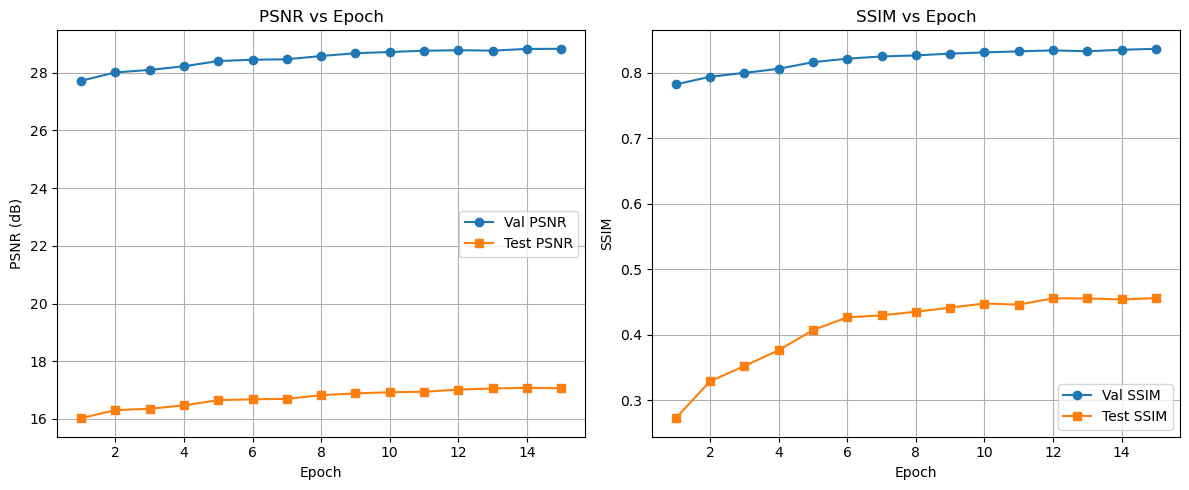

In [9]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric, structural_similarity as ssim_metric

# Assume UNet256, val_loader, and test_loader defined earlier
patches_folder_test = "test_patches_YZ"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update test_loader if needed
# test_loader returns (inp, tgt, fn), so evaluate_model must unpack three

checkpoint_dir = "Train_UNet256_hf"
num_epochs = 15

epochs = list(range(1, num_epochs + 1))
val_psnrs, val_ssims = [], []
test_psnrs, test_ssims = [], []

def evaluate_model(model, loader):
    total_psnr = total_ssim = n = 0
    model.eval()
    with torch.no_grad():
        for batch in loader:
            # Handle 2-tuple or 3-tuple
            if len(batch) == 3:
                inp, tgt, _ = batch
            else:
                inp, tgt = batch
            inp = inp.to(device)
            tgt = tgt.to(device)
            out = model(inp).clamp(0,1)
            pred = out.cpu().squeeze().numpy()
            true = tgt.cpu().squeeze().numpy()
            total_psnr += psnr_metric(true, pred, data_range=1.0)
            total_ssim += ssim_metric(true, pred, data_range=1.0)
            n += 1
    return total_psnr / n, total_ssim / n

# Loop through epochs
for epoch in epochs:
    ckpt = os.path.join(checkpoint_dir, f"UNet256_epoch{epoch:02d}.pth")
    state = torch.load(ckpt, map_location=device)
    model = UNet256().to(device)
    model.load_state_dict(state)

    vp, vs = evaluate_model(model, val_loader)
    tp, ts = evaluate_model(model, test_loader)

    val_psnrs.append(vp)
    val_ssims.append(vs)
    test_psnrs.append(tp)
    test_ssims.append(ts)

    print(f"Epoch {epoch:02d} | Val PSNR={vp:.2f}, SSIM={vs:.4f} | Test PSNR={tp:.2f}, SSIM={ts:.4f}")

# Plotting
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, val_psnrs, 'o-', label='Val PSNR')
plt.plot(epochs, test_psnrs, 's-', label='Test PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, val_ssims, 'o-', label='Val SSIM')
plt.plot(epochs, test_ssims, 's-', label='Test SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
import os
import torch
from PIL import Image

# 假设 UNet256 类和 val_dataset 已在前面定义
# 其中 val_dataset 是 Plain8xDataset，具有属性 fns 列表

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 加载 epoch15 模型权重
checkpoint = "Train_UNet256_hf/UNet256_epoch15.pth"
state = torch.load(checkpoint, map_location=device, weights_only=True)
model = UNet256().to(device)
model.load_state_dict(state)
model.eval()

# 2. 创建输出文件夹
output_dir = "val_epoch15_outputs"
os.makedirs(output_dir, exist_ok=True)

# 3. 逐张运行验证集推理并保存结果
#    val_dataset __getitem__ 返回 (inp, tgt)，但我们只需 inp；
#    文件名从 val_dataset.fns 列表中获取
with torch.no_grad():
    for idx, fn in enumerate(val_dataset.fns):
        inp, _ = val_dataset[idx]            # inp: [1,256,256]
        inp = inp.unsqueeze(0).to(device)     # [1,1,256,256]
        pred = model(inp).clamp(0,1).cpu().squeeze().numpy()  # [256,256]
        img_arr = (pred * 255.0).round().astype('uint8')
        Image.fromarray(img_arr).save(os.path.join(output_dir, fn))

print(f"Validation outputs saved to '{output_dir}/'")


Validation outputs saved to 'val_epoch15_outputs/'
